# FRF_Currituck Sound Station 3: Vertical Diffuse Attenuation Coefficient for Downwelling Photosynthetic Radiance EDA


python netcdf4 documentation: http://unidata.github.io/netcdf4-python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4
import time
import datetime

import sklearn.metrics
from sklearn.linear_model import LinearRegression

%matplotlib inline

### Read csv files for station 03, load into a dataframe, and wrangle...

In [34]:
data_path='/Users/paulp/GoogleDrive/projects/CurrituckSnd/CS_Stations/'

CS03_Kd=pd.read_csv(data_path+'CS03/FRF_CS03_Kd.csv').drop(['dt'], axis=1)

## Set date time values to Python datetime types, and round to nearest 1 second, on UT coordinated...
CS03_Kd['datetime'] = pd.to_datetime(CS03_Kd['datetime'], utc=True).dt.round('1s')

## Assign datetime field to data frame index
CS03_Kd.set_index('datetime', inplace=True)

## Aggregate sensor record indices in each of the three dataframes to the full day
CS03_Kd=CS03_Kd.resample('D').mean().copy()

CS03_Kd.head()

,PAR_Kd
datetime,
2016-05-01 00:00:00+00:00,NaN
2016-05-02 00:00:00+00:00,1.681380
2016-05-03 00:00:00+00:00,1.324682
2016-05-04 00:00:00+00:00,2.464305
2016-05-05 00:00:00+00:00,4.344363


### Some initial 'looks' at the Kd data:

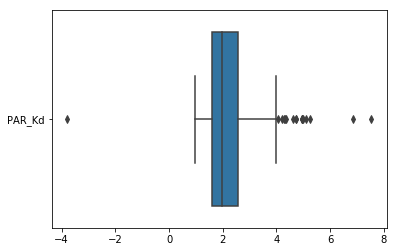

In [35]:
sns.boxplot(data=CS03_Kd, orient='h')

### Station Summary:

In [55]:
CS03_WQ.describe()

,turbidity_upper,turbidity_lower,water_temp,salinity
count,611.000000,212.000000,638.000000,636.000000
mean,20.433143,18.521464,18.475558,1.847649
std,15.580892,20.554438,7.737088,1.090832
min,0.484000,3.441756,0.133416,0.334342
25%,10.389098,6.957362,11.456677,0.905168
50%,15.352807,10.466897,18.786992,1.839952
75%,25.489680,20.478423,25.294187,2.309767
max,118.660513,127.663544,31.581296,5.793599


In [ ]:
{'water_temp': [19.587210,21.359987,18.475558], 'salinity': [2.559371,2.414230,1.847649], 'pH': [8.182356,8.125634,,], 
 'turbidity': [14.723885,14.312783,20.433143],
 'chlorophyll': [9.422746,9.610058,,],
                    'DOsat':[106.782628,104.803038,,], 'DOmass': [9.838875,9.286667,,], 'blueGreenAlgae': [20.616158,27.164130,,], 
 'fDOM':[85.149616,66.421834,,], 
                    'waveHs':[0.228047,0.202883,0.140811], 'currents':[0.100759,0.082455,0.278409] }

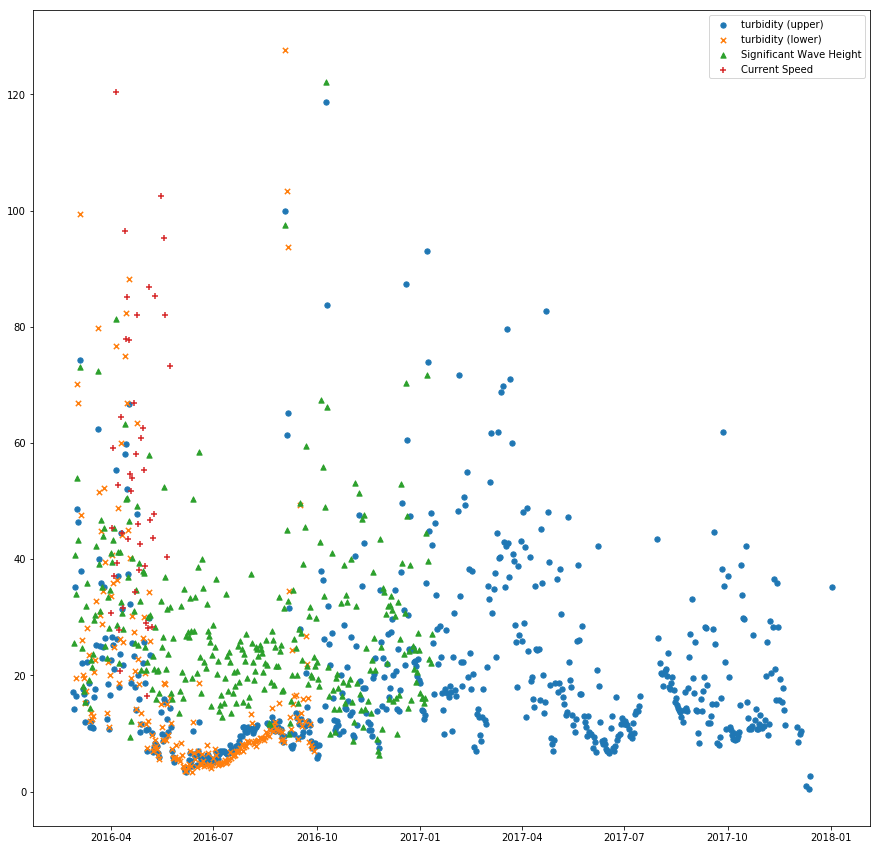

In [52]:
plt.subplots(figsize=(15,15))
    
plt.scatter(CS03_WQ.index, CS03_WQ['turbidity_upper'], s=28, marker='o', label='turbidity (upper)')
plt.scatter(CS03_WQ.index, CS03_WQ['turbidity_lower'], s=28, marker='x', label='turbidity (lower)')
plt.scatter(CS03_WV.index, CS03_WV['waveHs']*200, s=28, marker='^', label='Significant Wave Height')
plt.scatter(CS03_WC.index, CS03_WC['currentSpeed']*200, s=28, marker='+', label='Current Speed')
plt.legend()

In [4]:
CS03_Kd.loc[CS03_Kd['PAR_Kd']  < 0 ]

,PAR_Kd
datetime,
2016-08-22 00:00:00+00:00,-3.797691


#### ??? Is the diffusion coefficient (Kd) defined over the range: $-\infty < Kd < 0$  ??? See boxplot (above)

If $K_d$ is computed as (Lambert-Beer):  $K_d={1 \over{z2-z1}} \ln({E_d(z_1) \over{E_d(z_2)} })$

then the answer is...

...probably not...for it would suggest actual amplification of the incident radiation, which seems unlikely, really unlikely, so...

I'm gonna delete it.

In [5]:
### drop the < 0 value(s) in the CS03_Kd data...
print(CS03_Kd.info())
CS03_Kd=CS03_Kd[CS03_Kd['PAR_Kd'] > 0 ]
print(CS03_Kd.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 626 entries, 2016-05-01 to 2018-01-16
Freq: D
Data columns (total 1 columns):
PAR_Kd    329 non-null float64
dtypes: float64(1)
memory usage: 9.8 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 328 entries, 2016-05-02 to 2018-01-02
Data columns (total 1 columns):
PAR_Kd    328 non-null float64
dtypes: float64(1)
memory usage: 5.1 KB
None


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


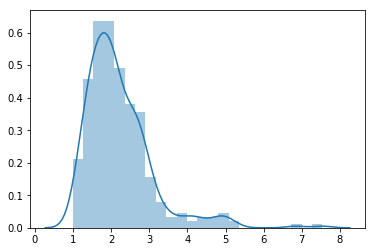

In [6]:
sns.distplot(CS03_Kd.dropna())

### Load the Water Quality, Waves, and Currents data for Stations 01, 02, and 03 and wrangle:

In [59]:
### Data loads...

## for Water Quality:
### Station 03 records turbidity at two levels and reports temperature and salinity in a separate data file...
CS03_WQT=pd.read_csv(data_path+'CS03/FRF_CS03-DTS12-top.csv', na_values=-999.990)
CS03_WQB=pd.read_csv(data_path+'CS03/FRF_CS03-DTS12-bot.csv', na_values=-999.990)
CS03_WQM=pd.read_csv(data_path+'CS03/FRF_CS03-Microcat.csv', na_values=-999.990)

## for Surface Waves:
CS03_WV=pd.read_csv(data_path+'CS03/FRF_CS03-SBE26_Waves_ALL.csv', na_values=-999.990).drop(['depth'], axis=1)

## for Uni-directional Currents:
CS03_WC=pd.read_csv(data_path+'CS03/FRF_CS03-ADOP_Currents_ALL.csv', na_values=-999.990).drop(['aveE','aveN','currentDirection','meanPressure'], axis=1)

### Now for the wrangle part...
## set datetime fields to datatime objects and round to whole second
CS03_WQT['datetime'] = pd.to_datetime(CS03_WQT['datetime'], utc=True).dt.round('1s')
CS03_WQB['datetime'] = pd.to_datetime(CS03_WQB['datetime'], utc=True).dt.round('1s')
CS03_WQM['datetime'] = pd.to_datetime(CS03_WQM['datetime'], utc=True).dt.round('1s')
CS03_WV['datetime'] = pd.to_datetime(CS03_WV['datetime'], utc=True).dt.round('1s')
CS03_WC['datetime'] = pd.to_datetime(CS03_WC['datetime'], utc=True).dt.round('1s')


## Assign datetime field to data frame index
CS03_WQT.set_index('datetime', inplace=True)
CS03_WQB.set_index('datetime', inplace=True)
CS03_WQM.set_index('datetime', inplace=True)
CS03_WV.set_index('datetime', inplace=True)
CS03_WC.set_index('datetime', inplace=True)


## Aggregate sensor record indices in each of the three dataframes to the full day
CS03_WQT=CS03_WQT.resample('D').mean().copy()
CS03_WQB=CS03_WQB.resample('D').mean().copy()
CS03_WQM=CS03_WQM.resample('D').mean().copy()
CS03_WV=CS03_WV.resample('D').mean().copy()
CS03_WC=CS03_WC.resample('D').mean().copy()

## Finally, merge all the individual dataframes associated with Station CS03:
CS03_WQ=pd.concat( [CS03_WQT, CS03_WQB, CS03_WQM], axis=1 )

## For Station 01:

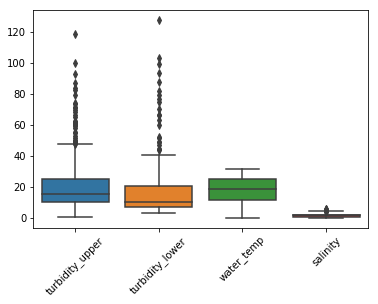

In [8]:
sns.boxplot(data=CS03_WQ)
plt.tick_params(axis='x', rotation=45)

### Station Summary:

In [10]:
CS03_WQ.describe()

,turbidity_upper,turbidity_lower,water_temp,salinity
count,611.000000,212.000000,638.000000,636.000000
mean,20.433143,18.521464,18.475558,1.847649
std,15.580892,20.554438,7.737088,1.090832
min,0.484000,3.441756,0.133416,0.334342
25%,10.389098,6.957362,11.456677,0.905168
50%,15.352807,10.466897,18.786992,1.839952
75%,25.489680,20.478423,25.294187,2.309767
max,118.660513,127.663544,31.581296,5.793599


### The Relationship between Chl-a and blue-green algae  (Chl-a, blue-green algae not measured at Station 03)

Bayley et al., 2003 indicate that Chl-a is a suitable proxy for phytoplankton abundance. Let's see what this relationship might look like for Currituck Sound

### Salinity at Station 03:

1.8476487430756954

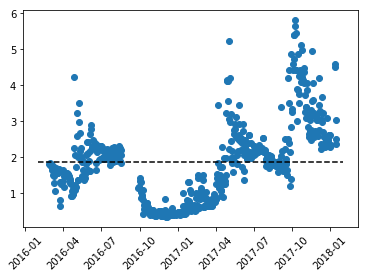

In [56]:
plt.scatter(CS03_WQ.index, CS03_WQ['salinity'])
plt.tick_params(axis='x', rotation=45)
plt.hlines(CS03_WQ['salinity'].mean(), '2016-02-01', '2018-01-31', linestyle='--')
CS03['salinity'].mean()

### Downwelling Diffuse Radiation Attenuation Coefficient - $K_d$ - _Linear_ Correlation Matrix

All station data included (less upper and lower PAR metrics)  

Annotations in matrix are Pearson Product Moment (r) statistics:

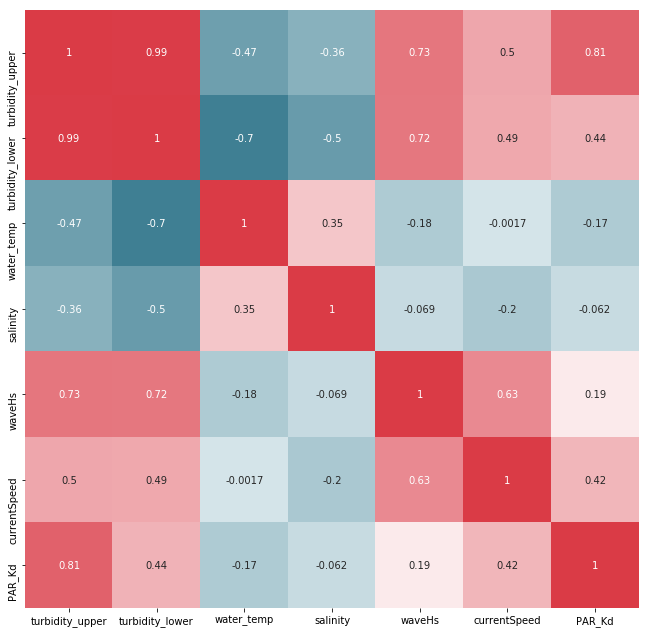

In [58]:
plt.subplots(figsize=(11,11) )
cmap = sns.diverging_palette(220, 10, center='light', as_cmap=True)
sns.heatmap( pd.concat([CS03_WQ, CS03_WV, CS03_WC, CS03_Kd],axis=1).corr(), cbar=False, annot=True, cmap=cmap )

### Downwelling Diffuse Radiation Attenuation Coefficient - $K_d$ - OLS _Exploratory_ Regression Plots

and its relationship to [assumed] controlling factors: surface waves, unidirectional currents, fDOM, Turbidity, and Chl-a 

$K_{d_{total}} = K_{d_{H_2O}} + K_{d_{fDOM}} + K_{d_{Chi-a}} + K_{d_{turbidity}} + K_{d_{surface waves}} + K_{d_{currents}}$

where: <br>
$K_{d_{H_2O}}$ is the optical density of water (not considered here) <br>
$K_{d_{fDOM}}$ is the contribution to $K_{d_{total}}$ from non-algal organic particulates <br>
$K_{d_{Chl-a}}$ is the contribution to $K_{d_{total}}$ from Chlorophyll-a (phytoplankton proxy)<br>
$K_{d_{turbidity}}$ is the contribution to $K_{d_{total}}$ from measured water column turbidity (total suspended inorganic particles)<br>
$K_{d_{surface waves}}$ is the contribution to $K_{d_{total}}$ directly and indirectly attributable to surface waves <br>
$K_{d_{currents}}$ is the contribution to $K_{d_{total}}$ from unidirectional water current(s) <br>

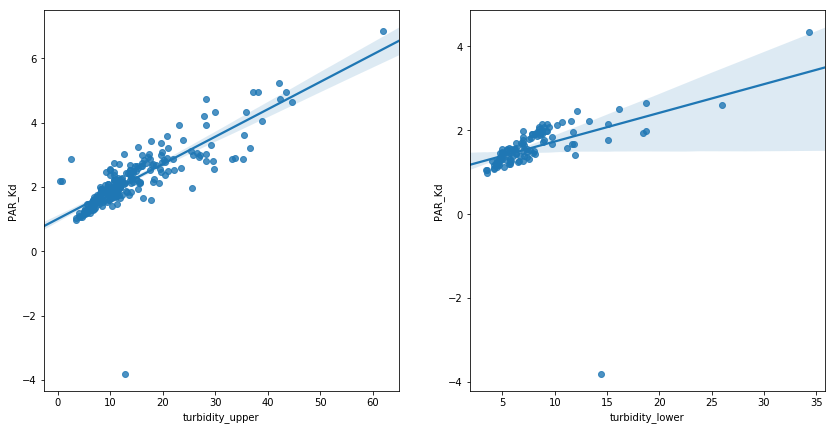

In [60]:
CS03=pd.concat([CS03_WQ, CS03_WV, CS03_WC, CS03_Kd],axis=1)

fig2=plt.figure(figsize=(14,7))
sns.regplot(x='turbidity_upper', y='PAR_Kd', data=CS03, fit_reg=True, order=1, ax=fig2.add_subplot(1,2,1))
sns.regplot(x='turbidity_lower', y='PAR_Kd', data=CS03, fit_reg=True, order=1, ax=fig2.add_subplot(1,2,2))

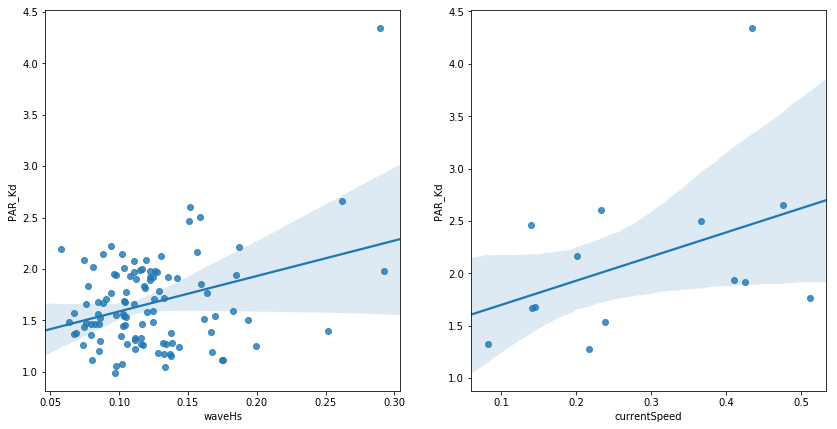

In [15]:
fig3=plt.figure(figsize=(14,7))

sns.regplot(x='waveHs', y='PAR_Kd', data=CS03, ax=fig3.add_subplot(1,2,1))
sns.regplot(x='currentSpeed', y='PAR_Kd', data=CS03, order=1, ax=fig3.add_subplot(1,2,2))

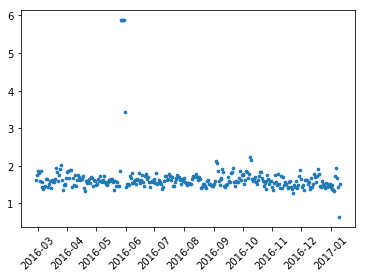

In [71]:
CS03['wavePeriod']=1/CS03['wavePeakFrequency']
plt.scatter(CS03.index, CS03.wavePeriod, s=7.0)
plt.tick_params(axis='x', rotation=45)

#### What if we could somehow remove the high-wind and storm wave effect from the data? 
#### How much might this attempt to isolate "typical" conditions impact results?

The 75th quantile for the significant wave height is 0.168001 m. So, 75% of the waves recorded at Station 03 are < 0.17 m. Though arbitrary, what if we assume (for now) that this 75% condition marks the upper boundary of "typical" wave energy conditions on Currituck Sound?

In [18]:
CS03_=CS03[CS03['waveHs'] < 0.17 ]

,PAR_Kd,turbidity_upper,turbidity_lower
PAR_Kd,1.000000,0.877240,0.782471
turbidity_upper,0.877240,1.000000,0.976529
turbidity_lower,0.782471,0.976529,1.000000


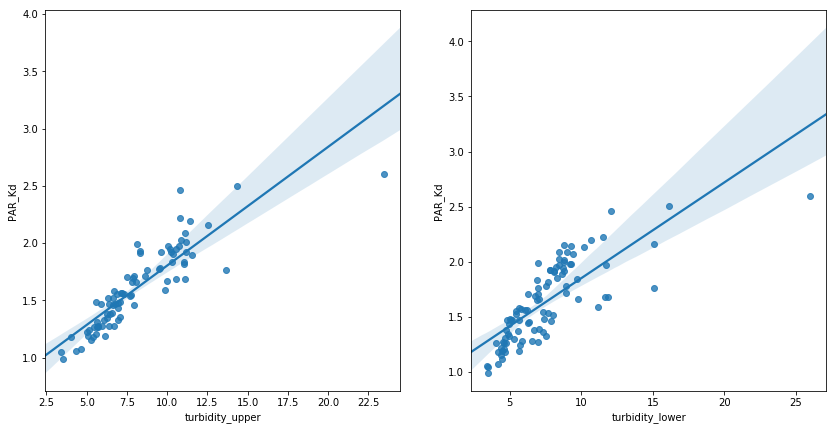

In [20]:
fig4=plt.figure(figsize=(14,7))
sns.regplot(x='turbidity_upper', y='PAR_Kd', data=CS03_, fit_reg=True, order=1, ax=fig4.add_subplot(1,2,1))
sns.regplot(x='turbidity_lower', y='PAR_Kd', data=CS03_, fit_reg=True, order=1, ax=fig4.add_subplot(1,2,2))

CS03_[['PAR_Kd', 'turbidity_upper','turbidity_lower']].corr()

,PAR_Kd,waveHs,currentSpeed
PAR_Kd,1.000000,0.124646,0.188285
waveHs,0.124646,1.000000,0.281587
currentSpeed,0.188285,0.281587,1.000000


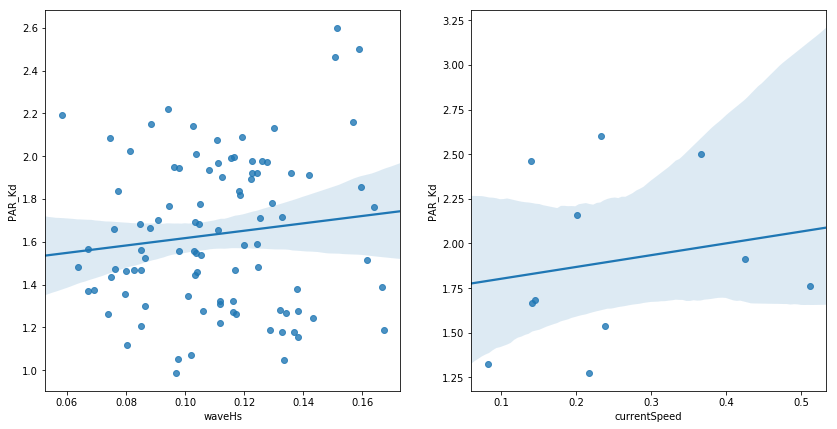

In [21]:
fig5=plt.figure(figsize=(14,7))

sns.regplot(x='waveHs', y='PAR_Kd', data=CS03_, ax=fig5.add_subplot(1,2,1))
sns.regplot(x='currentSpeed', y='PAR_Kd', data=CS03_, order=1, ax=fig5.add_subplot(1,2,2))

CS03_[['PAR_Kd','waveHs','currentSpeed']].corr()

### Multiple Regression Experiment:

In [26]:
#Instantiate the regression model and setting parameters if any,
reg_model = LinearRegression(normalize=True)

R=CS03[['turbidity_upper','turbidity_lower','waveHs','currentSpeed','PAR_Kd']].dropna()
X=R[['turbidity_upper','turbidity_lower','waveHs','currentSpeed']]
y=R[['PAR_Kd']]

reg_model.fit(X, y)

P=reg_model.predict(X)

#outputs the coefficients
print('Intercept :', reg_model.intercept_[0], '\n')
print(pd.DataFrame({'features':X.columns,'coeficients':reg_model.coef_[0]}))

print("R^2: {:.2f}".format(reg_model.score(X, y)))

Intercept : 0.09142133044665357 

          features  coeficients
0  turbidity_upper     0.278906
1  turbidity_lower    -0.193248
2           waveHs    10.237080
3     currentSpeed    -1.378384
R^2: 0.90


Text(0,0.5,'Observed Kd')

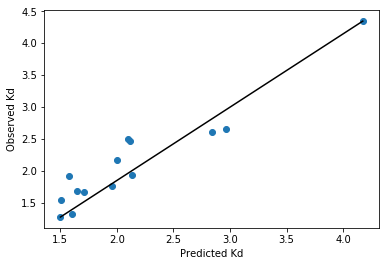

In [27]:
plt.scatter(P,R['PAR_Kd'])
plt.plot([P.min(),P.max()],[R['PAR_Kd'].min(), R['PAR_Kd'].max()], c='black')
plt.xlabel('Predicted Kd')
plt.ylabel('Observed Kd')

In [29]:
import statsmodels.api as sm

model03 = sm.OLS(y, sm.add_constant(X)).fit()
model03.summary()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 PAR_Kd   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     19.71
Date:                Tue, 07 Aug 2018   Prob (F-statistic):           0.000178
Time:                        11:16:55   Log-Likelihood:              -0.020760
No. Observations:                  14   AIC:                             10.04
Df Residuals:                       9   BIC:                             13.24
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0914      0.345      0.265      0.797      -0.689       0.872
turbidity_upper     0.2789      0.179      1.554      0.155      -0.127       0.685
turbidity_lower    -0.1932      0.163     -1.187      0.266      -0.561       0.175
waveHs             10.2371      3.662      2.796      0.021       1.954      18.520
currentSpeed       -1.3784      0.847     -1.628      0.138      -3.293       0.537
==============================================================================
Omnibus:                        2.933   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.231   Jarque-Bera (JB):                1.263
Skew:                           0.323   Prob(JB):                        0.532
Kurtosis:                       1.678   Cond. No.                     1.02e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Regressing under "typical" conditions:

In [30]:
R=CS03_[['turbidity_upper','turbidity_lower','waveHs','currentSpeed',
                                'PAR_Kd']].dropna()
X=R[['turbidity_upper','turbidity_lower','waveHs','currentSpeed']]
y=R[['PAR_Kd']]
model11 = sm.OLS(y, sm.add_constant(X)).fit()
model11.summary()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 PAR_Kd   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     5.169
Date:                Tue, 07 Aug 2018   Prob (F-statistic):             0.0378
Time:                        11:20:59   Log-Likelihood:                 1.4105
No. Observations:                  11   AIC:                             7.179
Df Residuals:                       6   BIC:                             9.169
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.4972      0.932     -0.533      0.613      -2.778       1.784
turbidity_upper     0.3075      0.300      1.027      0.344      -0.425       1.041
turbidity_lower    -0.2397      0.275     -0.870      0.418      -0.914       0.434
waveHs             17.3395      9.266      1.871      0.110      -5.335      40.014
currentSpeed       -1.6418      1.158     -1.417      0.206      -4.476       1.193
==============================================================================
Omnibus:                        2.260   Durbin-Watson:                   2.747
Prob(Omnibus):                  0.323   Jarque-Bera (JB):                1.103
Skew:                          -0.407   Prob(JB):                        0.576
Kurtosis:                       1.680   Cond. No.                     1.97e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""